In [19]:
initial_path = 'peptide-QML/'
# initial_path = '../'

In [20]:
day = "0811"
name_notebook = day + "-mh_em_1qm.ipynb"

#ask the user if that is correct, if he says yes kkep going, otherwise stop
import sys
answer = input("{} is the name of the notebook | Is that correct? (y/n): ".format(name_notebook))
if answer != "y":
    print("Please, change the name of the notebook")
    sys.exit()

In [21]:
import numpy as np

In [22]:
import sys
sys.path.append(initial_path)

%load_ext autoreload
%autoreload 2
from my_code import functions as f
from my_code import pytorch_model as ptm
from my_code import quantum_nodes as qn
from my_code import pytorch_wrappers as pw

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Data

In [23]:
data_file_path = initial_path + 'data/Scores/PET/generated/bb14_Strings_Energies_10_000_8_aa.txt'  # Replace with the actual path to your 'data.txt' file
string_list, number_list = f.read_data_file(data_file_path)
score_list = np.array(number_list)/np.max(number_list)*10
vector_list = np.array([f.string_to_numbers(string) for string in string_list]) # one hot encoding

In [24]:
X, Y, X_validation, Y_validation = f.create_validating_set(vector_list, score_list, percentage=0.1)

In [25]:
# Define the dataset
input_data = ptm.torch.tensor(X) 
target_data = ptm.torch.tensor(Y).view(-1, 1)

# Define the validation set
input_validation = ptm.torch.tensor(X_validation)
target_validation = ptm.torch.tensor(Y_validation).view(-1, 1)

# Quantum node

In [26]:
n_aminoacids = len(string_list[0])

In [27]:
quantum_layer = qn.circuit(
    n_qubits = n_aminoacids, 
    device = "default.qubit.torch",
    device_options = {'shots': None},
    embedding = qn.parts.AngleEmbedding, 
    # embedding_ansatz = qn.parts.Ansatz_11,
    block_ansatz = qn.parts.Ansatz_11,
    final_ansatz = qn.parts.Ansatz_11,
    measurement = qn.parts.Measurement('Z', 1),
    # embedding_n_layers = 4,
    # different_inputs_per_layer = True,
    block_n_layers = 50,
    # wrapper_qlayer = pw.QLayer,
    wrapper_qlayer = None,
)

/usr/lib/python3.8/_collections_abc.py:832: MatplotlibDeprecationWarning: 
The examples.directory rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2. In the future, examples will be found relative to the 'datapath' directory.
  self[key] = other[key]
/usr/lib/python3.8/_collections_abc.py:832: MatplotlibDeprecationWarning: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
  self[key] = other[key]
/usr/lib/python3.8/_collections_abc.py:832: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2.
  self[key] = other[key]
/usr/lib/python3.8/_collections_abc.py:832: MatplotlibDeprecationWarning: 
The verbose.fileo rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
  self[key] = other[key]
/usr/lib/python3.8/_collections_abc.py:832: MatplotlibDeprecationWarning: 
The verbose.level rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
  

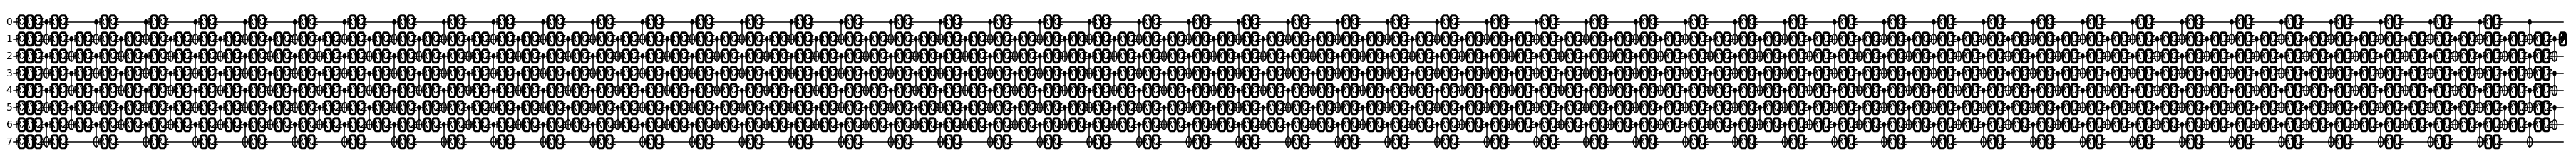

In [28]:
quantum_layer.draw(size=(50,3))

# Hybrid model

In [29]:
import torch.nn as nn
import torch
    
class Reshape(nn.Module):
    def __init__(self):
        super(Reshape, self).__init__()

    def forward(self, x):
        dims = len(x.shape)
        return torch.transpose(x, dims-2, dims-1).reshape(x.shape[-3] if dims==3 else 1, x.shape[-2]*x.shape[-1]).squeeze()

In [30]:
layers =  [ptm.nn.Embedding(num_embeddings=19, embedding_dim=quantum_layer.input_shape[0]//n_aminoacids), Reshape()]
layers += [quantum_layer(), ptm.nn.Linear(1,1)]


In [31]:
# Create model and set data:
model = ptm.pytorch_model(
    layers,    
    save_options = {'initial_path': initial_path, 'name_notebook': name_notebook},
)
model.set_data(
    data_X=input_data, 
    data_Y=target_data, 
    data_X_validation=input_validation,
    data_Y_validation=target_validation
)

In [32]:
print(model(input_data[0:2]))
print(model(input_data[1]))

tensor([[0.4988],
        [0.4922]], grad_fn=<AddmmBackward>)
tensor([0.4922], grad_fn=<AddBackward0>)


In [33]:
model.keep_track_params=False

In [34]:
import torch.optim as optim

# ask the user if he wants to start the training
out = input("Do you want to start the training? (y/n) ")
if out != 'y':
    sys.exit()

# train the model
model.train(
    optimizer= optim.Adam,
    optimizer_options={'lr': 0.5},
    num_epochs = 100,                
    batch_size = 32,
    # initialization_options = [
    #     {
    #         'type': 'normal_',
    #         'layer': len(model.model)-1, 
    #         'name': 'bias',
    #         'options': {'mean': 100, 'std': 10},
    #     },{
    #         'type': 'normal_',
    #         'layer': len(model.model)-1,
    #         'name': 'weight',
    #         'options': {'mean': 200, 'std': 10},
    #     },
    # ]
)

Epoch [0/100], Loss: 0.8949, Loss validation: 0.8945
	 Validation string, 	 i: 0; 	 prediction: 3.2320, 	 target: -0.4186, 	 loss: 8.7209
	 Validation string, 	 i: 1; 	 prediction: 3.2343, 	 target: 0.5745, 	 loss: 4.6302
	 Validation string, 	 i: 2; 	 prediction: 3.1846, 	 target: 6.5731, 	 loss: 0.5155
Epoch [1/100], Loss: 0.5081, Loss validation: 0.5213, Time remaining: ~10.0h 11.0m 8s
	 Validation string, 	 i: 0; 	 prediction: 3.2722, 	 target: -0.4186, 	 loss: 8.8170
	 Validation string, 	 i: 1; 	 prediction: 3.2241, 	 target: 0.5745, 	 loss: 4.6124
	 Validation string, 	 i: 2; 	 prediction: 3.1331, 	 target: 6.5731, 	 loss: 0.5234
Epoch [2/100], Loss: 0.5042, Loss validation: 0.5175, Time remaining: ~9.0h 33.0m 37s
	 Validation string, 	 i: 0; 	 prediction: 3.2871, 	 target: -0.4186, 	 loss: 8.8525
	 Validation string, 	 i: 1; 	 prediction: 3.6279, 	 target: 0.5745, 	 loss: 5.3152
	 Validation string, 	 i: 2; 	 prediction: 3.5749, 	 target: 6.5731, 	 loss: 0.4561
Epoch [3/100], L

In [35]:
# save string of the model
model.save_str(
    metadata={
        "data_file_path": data_file_path,
    }
)

Saved in:  peptide-QML/checkpoints/0811/txts/0811-mh_em_1qm_model_str_2.txt


Saved in:  peptide-QML/checkpoints/0811/plots/0811-mh_em_1qm_losses_batches_2.png


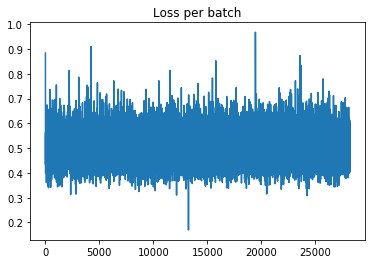

Saved in:  peptide-QML/checkpoints/0811/plots/0811-mh_em_1qm_losses_epoch_2.png


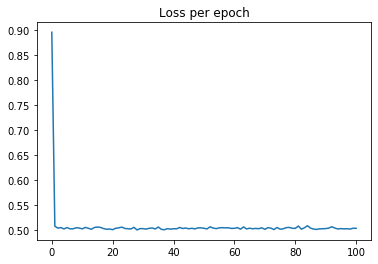

Saved in:  peptide-QML/checkpoints/0811/plots/0811-mh_em_1qm_losses_epoch_validation_2.png


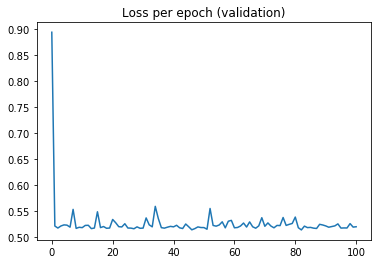

In [36]:
# plot the losses of the trainig loop and save the figures
model.plot_losses(save=True)

In [37]:
# plot how the average of the parameters in each layer changes over time, and save that
for layer in model.model.state_dict().keys():
    model.plot_parameter(layer=layer, save=True)

No parameters saved, so no plot can be made. Please set keep_track_params=True when initializing the model or do model.keep_track_params = True.
No parameters saved, so no plot can be made. Please set keep_track_params=True when initializing the model or do model.keep_track_params = True.
No parameters saved, so no plot can be made. Please set keep_track_params=True when initializing the model or do model.keep_track_params = True.
No parameters saved, so no plot can be made. Please set keep_track_params=True when initializing the model or do model.keep_track_params = True.
No parameters saved, so no plot can be made. Please set keep_track_params=True when initializing the model or do model.keep_track_params = True.


In [38]:
# model.plot_parameter(layer='7.weights', index=50)

In [39]:
#save all the parameters of the model and the intermediate parameters of the model
model.save_state_dict(intermediate=False)

Model saved as peptide-QML/checkpoints/0811/models/0811-mh_em_1qm_2.pth


Saved in:  peptide-QML/checkpoints/0811/plots/0811-mh_em_1qm_validation_2.png


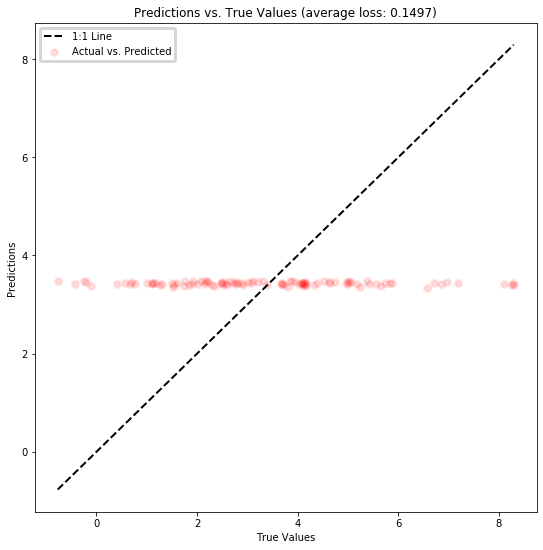

In [40]:
model.plot_validation(save=True, fig_size=(9,9), percentatge=0.1)

In [41]:
# print validation and save it
model.print_validation(save=True, precision=4, percentatge=0.1)

i: 0, 		 target: -0.4186, 	 prediction: 3.4127, 	 loss: 9.1526
i: 1, 		 target: 1.5992, 	 prediction: 3.4296, 	 loss: 1.1446
i: 2, 		 target: 2.7119, 	 prediction: 3.4337, 	 loss: 0.2662
i: 3, 		 target: 5.3775, 	 prediction: 3.4745, 	 loss: 0.3539
i: 4, 		 target: 3.9452, 	 prediction: 3.4516, 	 loss: 0.1251
i: 5, 		 target: 4.6122, 	 prediction: 3.4593, 	 loss: 0.2500
i: 6, 		 target: 3.7996, 	 prediction: 3.3652, 	 loss: 0.1143
i: 7, 		 target: 2.9108, 	 prediction: 3.4026, 	 loss: 0.1689
i: 8, 		 target: 1.2554, 	 prediction: 3.3920, 	 loss: 1.7018
i: 9, 		 target: 4.0771, 	 prediction: 3.4396, 	 loss: 0.1564
i: 10, 		 target: 0.5745, 	 prediction: 3.4465, 	 loss: 4.9994
i: 11, 		 target: 4.1703, 	 prediction: 3.4399, 	 loss: 0.1752
i: 12, 		 target: 2.2941, 	 prediction: 3.4041, 	 loss: 0.4839
i: 13, 		 target: 0.6627, 	 prediction: 3.4092, 	 loss: 4.1443
i: 14, 		 target: 3.0663, 	 prediction: 3.4302, 	 loss: 0.1187
i: 15, 		 target: 1.7370, 	 prediction: 3.3725, 	 loss: 0.9416
i

In [42]:
# push changes to git
if initial_path != '../':
    !cd peptide-QML && git add . && git commit -m "data trained model" && git push

[main 0f69c1c0] data trained model
 7 files changed, 142 insertions(+)
 create mode 100644 checkpoints/0811/models/0811-mh_em_1qm_2.pth
 create mode 100644 checkpoints/0811/plots/0811-mh_em_1qm_losses_batches_2.png
 create mode 100644 checkpoints/0811/plots/0811-mh_em_1qm_losses_epoch_2.png
 create mode 100644 checkpoints/0811/plots/0811-mh_em_1qm_losses_epoch_validation_2.png
 create mode 100644 checkpoints/0811/plots/0811-mh_em_1qm_validation_2.png
 create mode 100644 checkpoints/0811/txts/0811-mh_em_1qm_model_str_2.txt
 create mode 100644 checkpoints/0811/txts/0811-mh_em_1qm_validation_2.txt
Enumerating objects: 20, done.
Counting objects: 100% (18/18), done.
Delta compression using up to 24 threads
Compressing objects: 100% (14/14), done.
Writing objects: 100% (14/14), 79.55 KiB | 7.23 MiB/s, done.
Total 14 (delta 2), reused 0 (delta 0)
remote: Resolving deltas: 100% (2/2), completed with 2 local objects.
To github.com:raulconchello/peptide-QML.git
   0f6e8f2b..0f69c1c0  main -> ma